
Processing dataset: rd100.tsp.gz
+--------------------------+-------------------+------------+
|        Algorithm         |      Distance     | Iterations |
+--------------------------+-------------------+------------+
|   Simple Hill Climbing   | 26708.88632072875 |    1000    |
| Stochastic Hill Climbing | 22621.67154229591 |    1760    |
|   Simulated Annealing    | 25212.08737807575 |    1000    |
+--------------------------+-------------------+------------+


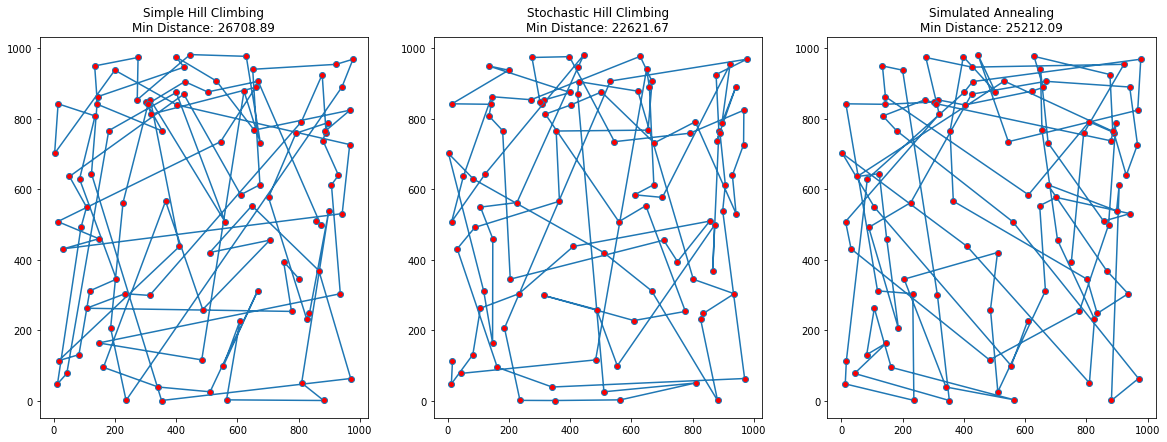


Processing dataset: eil101.tsp.gz
+--------------------------+--------------------+------------+
|        Algorithm         |      Distance      | Iterations |
+--------------------------+--------------------+------------+
|   Simple Hill Climbing   | 1592.6885684379524 |    1000    |
| Stochastic Hill Climbing | 1346.2005898846198 |    2537    |
|   Simulated Annealing    | 1799.7353888694927 |    1000    |
+--------------------------+--------------------+------------+


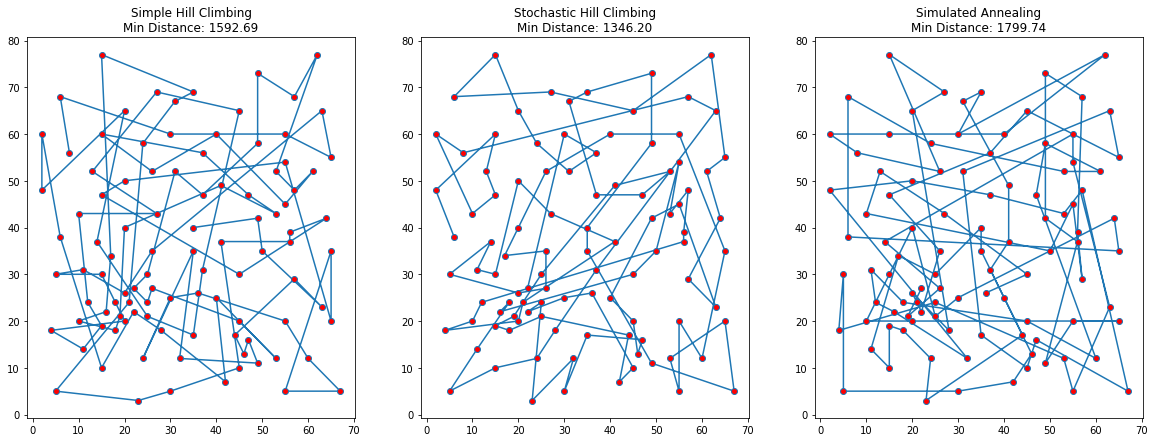


Processing dataset: a280.tsp.gz
+--------------------------+--------------------+------------+
|        Algorithm         |      Distance      | Iterations |
+--------------------------+--------------------+------------+
|   Simple Hill Climbing   | 19383.183917076767 |    1000    |
| Stochastic Hill Climbing | 16354.092223254742 |    1927    |
|   Simulated Annealing    | 19547.556672017738 |    1000    |
+--------------------------+--------------------+------------+


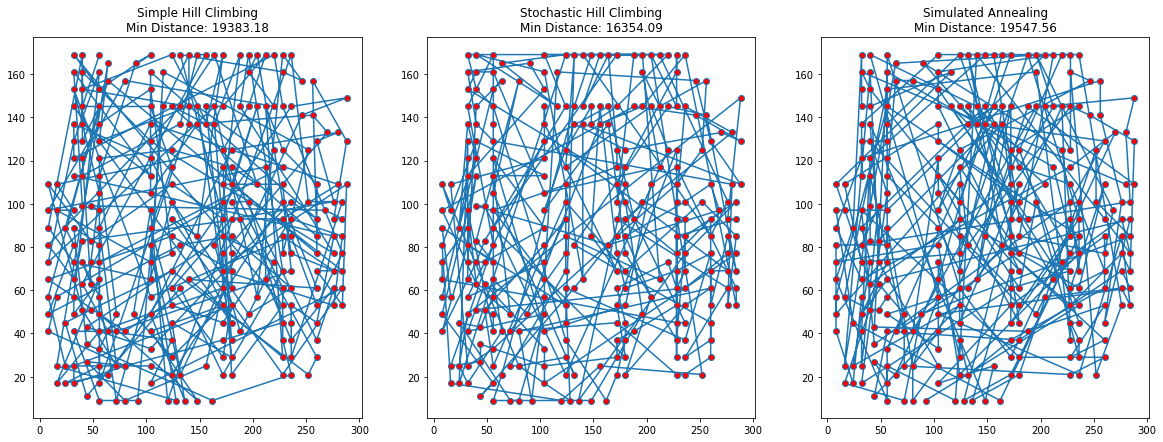


Processing dataset: d198.tsp.gz
+--------------------------+-------------------+------------+
|        Algorithm         |      Distance     | Iterations |
+--------------------------+-------------------+------------+
|   Simple Hill Climbing   | 93328.93483192397 |    1000    |
| Stochastic Hill Climbing |  70296.3035110443 |    3823    |
|   Simulated Annealing    | 91132.32079530884 |    1000    |
+--------------------------+-------------------+------------+


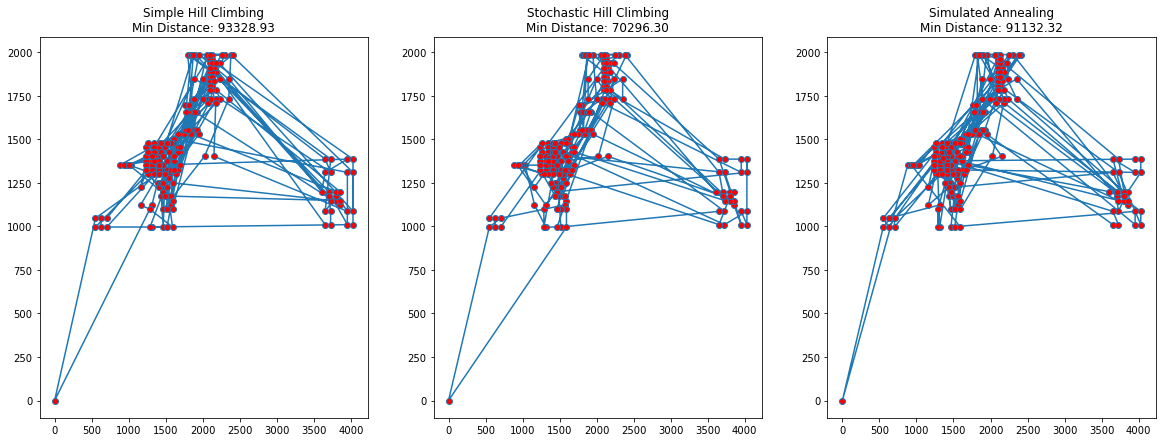


Processing dataset: ch150.tsp.gz
+--------------------------+--------------------+------------+
|        Algorithm         |      Distance      | Iterations |
+--------------------------+--------------------+------------+
|   Simple Hill Climbing   | 28585.55061499773  |    1000    |
| Stochastic Hill Climbing | 21833.170624400795 |    3225    |
|   Simulated Annealing    | 27984.546390139985 |    1000    |
+--------------------------+--------------------+------------+


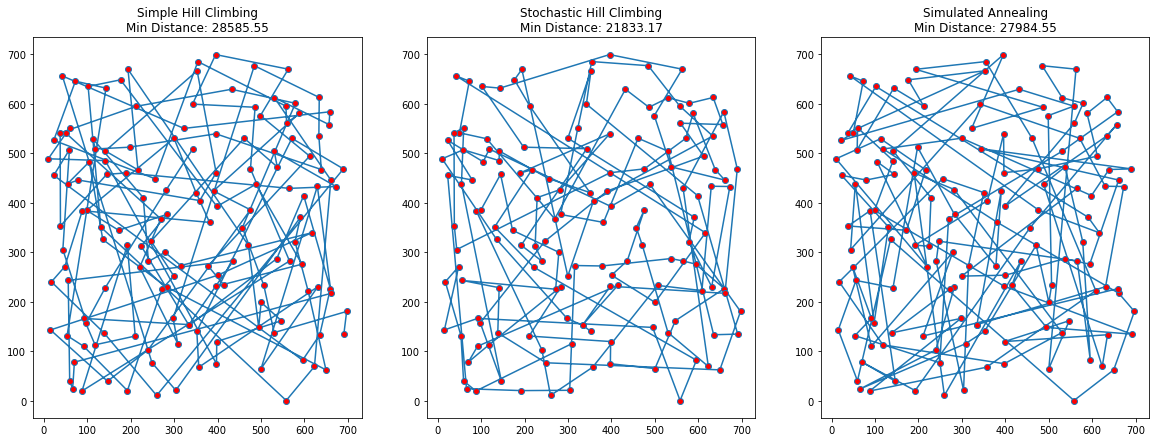


Comparative Analysis Summary:
+---------------+--------------------------+--------------------+------------+
|    Dataset    |      Best Algorithm      |   Best Distance    | Iterations |
+---------------+--------------------------+--------------------+------------+
|  rd100.tsp.gz | Stochastic Hill Climbing | 22621.67154229591  |    1760    |
| eil101.tsp.gz | Stochastic Hill Climbing | 1346.2005898846198 |    2537    |
|  a280.tsp.gz  | Stochastic Hill Climbing | 16354.092223254742 |    1927    |
|  d198.tsp.gz  | Stochastic Hill Climbing |  70296.3035110443  |    3823    |
|  ch150.tsp.gz | Stochastic Hill Climbing | 21833.170624400795 |    3225    |
+---------------+--------------------------+--------------------+------------+


In [1]:
import numpy as np
import scipy.spatial.distance as dist
import gzip
import time
import matplotlib.pyplot as plt
from colorama import Fore, Style
from prettytable import PrettyTable

def read_tsp_data(file_path):
    with gzip.open(file_path, 'rt') as file:
        lines = file.readlines()

    cities = []
    coordinates = []

    for line in lines:
        if line.startswith("DIMENSION"):
            num_cities = int(line.split(":")[1])
            break

    for line in lines[6:6 + num_cities]:
        city_data = line.strip().split()
        cities.append(city_data[0])
        coordinates.append([float(x) for x in city_data[1:]])

    return cities, np.array(coordinates)

def compute_distance_matrix(coordinates):
    return dist.squareform(dist.pdist(coordinates))

def tsp_objective_function(order, distance_matrix):
    rotated_order = np.roll(order, -1)
    return np.sum(distance_matrix[order, rotated_order])

def hill_climbing_iteration(current_solution, distance_matrix):
    idx1, idx2 = np.random.choice(len(current_solution), size=2, replace=False)
    neighbor_solution = current_solution.copy()
    neighbor_solution[idx1], neighbor_solution[idx2] = neighbor_solution[idx2], neighbor_solution[idx1]

    neighbor_distance = tsp_objective_function(neighbor_solution, distance_matrix)
    return neighbor_solution, neighbor_distance

def hill_climbing(initial_solution, distance_matrix, num_iterations=1000):
    current_solution = initial_solution.copy()
    current_distance = tsp_objective_function(current_solution, distance_matrix)
    iterations = 0

    for _ in range(num_iterations):
        neighbor_solution, neighbor_distance = hill_climbing_iteration(current_solution, distance_matrix)

        if neighbor_distance < current_distance:
            current_solution, current_distance = neighbor_solution, neighbor_distance

        iterations += 1

    return current_solution, current_distance, iterations

def stochastic_hill_climbing(initial_solution, distance_matrix):
    current_solution = initial_solution
    current_distance = tsp_objective_function(current_solution, distance_matrix)
    iterations = 0
    no_improvement_count = 0  # Keep track of no improvement iterations

    while no_improvement_count < 100:  # Break if no improvement after 100 iterations
        neighbor_solution, neighbor_distance = hill_climbing_iteration(current_solution, distance_matrix)

        if neighbor_distance < current_distance:
            current_solution, current_distance = neighbor_solution, neighbor_distance
            no_improvement_count = 0  # Reset if improvement occurs
        else:
            no_improvement_count += 1

        iterations += 1

    return current_solution, current_distance, iterations

def generate_neighbor_solution(current_solution):
    idx1, idx2 = np.random.choice(len(current_solution), size=2, replace=False)
    neighbor_solution = current_solution.copy()
    neighbor_solution[idx1], neighbor_solution[idx2] = neighbor_solution[idx2], neighbor_solution[idx1]
    return neighbor_solution

def simulated_annealing(initial_solution, distance_matrix, initial_temperature=1000, cooling_rate=0.95, num_iterations=1000):
    current_solution = initial_solution
    current_distance = tsp_objective_function(current_solution, distance_matrix)
    best_solution = current_solution
    best_distance = current_distance
    iterations = 0

    temperature = initial_temperature

    for _ in range(num_iterations):
        neighbor_solution = generate_neighbor_solution(current_solution)
        neighbor_distance = tsp_objective_function(neighbor_solution, distance_matrix)

        if neighbor_distance < current_distance or np.random.rand() < np.exp((current_distance - neighbor_distance) / temperature):
            current_solution = neighbor_solution
            current_distance = neighbor_distance

            if current_distance < best_distance:
                best_solution = current_solution
                best_distance = current_distance

        temperature *= cooling_rate
        iterations += 1

    return best_solution, best_distance, iterations

def plot_path(ax, coordinates, order, title):
    ordered_coordinates = coordinates[order]
    ax.plot(ordered_coordinates[:, 0], ordered_coordinates[:, 1], 'o-', mfc='r')
    ax.set_title(title)

def select_best_local_search(initial_solution, distance_matrix):
    # Run each local search method and compare results
    final_solution_hill_climbing, min_distance_hill_climbing, iterations_hill_climbing = hill_climbing(initial_solution.copy(), distance_matrix)
    final_solution_stochastic, min_distance_stochastic, iterations_stochastic = stochastic_hill_climbing(initial_solution.copy(), distance_matrix)
    final_solution_simulated_annealing, min_distance_simulated_annealing, iterations_simulated_annealing = simulated_annealing(initial_solution.copy(), distance_matrix)

    # Find the best method based on minimum distance
    methods = {
        'Simple Hill Climbing': min_distance_hill_climbing,
        'Stochastic Hill Climbing': min_distance_stochastic,
        'Simulated Annealing': min_distance_simulated_annealing
    }

    best_method = min(methods, key=methods.get)
    best_solution = None
    best_distance = None
    best_iterations = None

    if best_method == 'Simple Hill Climbing':
        best_solution = final_solution_hill_climbing
        best_distance = min_distance_hill_climbing
        best_iterations = iterations_hill_climbing
    elif best_method == 'Stochastic Hill Climbing':
        best_solution = final_solution_stochastic
        best_distance = min_distance_stochastic
        best_iterations = iterations_stochastic
    elif best_method == 'Simulated Annealing':
        best_solution = final_solution_simulated_annealing
        best_distance = min_distance_simulated_annealing
        best_iterations = iterations_simulated_annealing

    return best_method, best_solution, best_distance, best_iterations

def main():
    datasets = ['rd100.tsp.gz', 'eil101.tsp.gz', 'a280.tsp.gz', 'd198.tsp.gz', 'ch150.tsp.gz']
    all_results = []

    # Loop over each dataset
    for dataset in datasets:
        print(f"\nProcessing dataset: {dataset}")
        cities, coordinates = read_tsp_data(f'{dataset}')
        distance_matrix = compute_distance_matrix(coordinates)

        np.random.seed(69)

        # Initialize a list to store all outcomes
        all_outcomes = []

        # Run each algorithm and capture results
        algorithms = [hill_climbing, stochastic_hill_climbing, simulated_annealing]
        algorithm_names = ['Simple Hill Climbing', 'Stochastic Hill Climbing', 'Simulated Annealing']

        for algorithm, name in zip(algorithms, algorithm_names):
            initial_solution = np.random.permutation(len(cities))
            solution, distance, iterations = algorithm(initial_solution, distance_matrix)
            all_outcomes.append((name, solution, distance, iterations))

        # Select the best outcome
        best_outcome = min(all_outcomes, key=lambda x: x[2])

        # Store results for comparative analysis
        all_results.append((dataset, best_outcome[0], best_outcome[2], best_outcome[3]))

        # Display results in a table
        table = PrettyTable()
        table.field_names = ["Algorithm", "Distance", "Iterations"]
        for name, _, distance, iterations in all_outcomes:
            if (name, _, distance) == best_outcome:
                table.add_row([Fore.GREEN + name + Style.RESET_ALL, distance, iterations])
            else:
                table.add_row([name, distance, iterations])
        print(table.get_string())

        # Plot the paths for each algorithm
        fig, axs = plt.subplots(1, len(algorithms), figsize=(20, 7))
        for i, (name, solution, distance, _) in enumerate(all_outcomes):
            plot_path(axs[i], coordinates, solution, f'{name}\nMin Distance: {distance:.2f}')
        plt.show()

    # Comparative analysis summary
    print("\nComparative Analysis Summary:")
    comparison_table = PrettyTable()
    comparison_table.field_names = ["Dataset", "Best Algorithm", "Best Distance", "Iterations"]
    for result in all_results:
        dataset, best_method, best_distance, best_iterations = result
        comparison_table.add_row([dataset, best_method, best_distance, best_iterations])
    
    print(comparison_table)

if __name__ == "__main__":
    main()
